# Using `memento` to analyze Interferon-B response in monocytes (with replicates)

Same as the simple binary testing scenario, but now accounting for sample intercepts. This assumes that while there is a global fixed effect, each sample (such as technical replicate, individual donor, mice) have their own intercept.

Data found at https://memento-examples.s3.us-west-2.amazonaws.com/pbmc-ifnb/interferon_filtered.h5ad. 

In [1]:
# This is only for development purposes

import sys
import memento
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import scanpy as sc
import memento

In [3]:
data_path = '/home/ubuntu/Data/tutorial_data/pbmc-ifnb/'

### Read IFN data and filter for monocytes

For `memento`, we need the raw count matrix. Preferrably, feed the one with all genes so that we can choose what genes to look at. `adata.X` should be a sparse matrix containing positive integers.

One of the columns in `adata.obs` should be the discrete groups to compare mean, variability, and co-variability across. In this case, it's called `stim`. 

The column containing the covariate that you want p-values for should either:
- Be binary (aka the column only contains two unique values, such as 'A' and 'B'. Here, the values are either 'stim' or 'ctrl'.
- Be numeric (aka the column contains -1, 0, -1 for each genotype value). 

I recommend changing the labels to something numeric (here, i use 0 for `ctrl` and 1 for `stim`). Otherwise, the sign of the DE/EV/DC testing will be very hard to interpret.

In [4]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
print(adata)

AnnData object with n_obs × n_vars = 5341 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_type'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_tsne'


In [5]:
adata.obs['stim'] = adata.obs['stim'].apply(lambda x: 0 if x == 'ctrl' else 1)

In [6]:
adata.obs[['ind', 'stim', 'cell']].sample(5)

,ind,stim,cell
index,,,
GGGTAACTATCACG-1,1244,0,CD14+ Monocytes
CCTATAACCTCAGA-1,1256,0,CD14+ Monocytes
ACTTAAGAAGCTAC-1,1244,0,CD14+ Monocytes
AAAGTTTGTCAGAC-1,1256,0,CD14+ Monocytes
TACTACACAAGGCG-1,1015,0,CD14+ Monocytes


### Details on designating replicates

`memento` creates groups of cells based on anything that should be considered a reasonable group; in the simple binary example, we just divide the cells into `stim` and `ctrl`. But we can easily further divide the cells into individuals by adding the `ind` column to the `label_columns` argument when calling `create_groups`.

Once we split up the data into many groups, `memento` runtime scales with the number of groups.

In [7]:
from scipy.sparse.csr import csr_matrix

/tmp/ipykernel_11722/1113556143.py:1: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.csr import csr_matrix


In [8]:
type(adata.X) == csr_matrix

True

In [9]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')

In [10]:
memento.create_groups(adata, label_columns=['stim', 'ind'])

In [11]:
memento.compute_1d_moments(adata,
    min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered. 

### Perform 1D hypothesis testing

Because we have many samples to consider, we can construct a design matrix with `pd.get_dummies`.

Here we simply fit separate intercepts to the different individuals. `stim_df` becomes the DataFrame containing the variable of interest (like the stimulation condition) and `cov_df` contains the covariates we might adjust for.

In [12]:
sample_meta = memento.get_groups(adata)
sample_meta['ind'] = sample_meta['ind'].astype('category') # make sure to not confuse ourselves in case replicate labels are numbers

In [13]:
sample_meta.head(3)

,stim,ind
sg^0^1016,0,1016
sg^0^1256,0,1256
sg^0^1015,0,1015


In [14]:
treatment_df = sample_meta[['stim']]
treatment_df.head(5)

,stim
sg^0^1016,0
sg^0^1256,0
sg^0^1015,0
sg^0^101,0
sg^0^1244,0


In [15]:
cov_df = pd.get_dummies(sample_meta['ind'].astype('category'))
cov_df.head(3)

,101,107,1015,1016,1039,1244,1256,1488
sg^0^1016,False,False,False,True,False,False,False,False
sg^0^1256,False,False,False,False,False,False,True,False
sg^0^1015,False,False,True,False,False,False,False,False


In [16]:
memento.ht_1d_moments(
    adata, 
    treatment=treatment_df,
    covariate=cov_df,
    num_boot=5000, 
    verbose=1,
    num_cpus=40)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    5.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   10.0s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:   16.4s
[Parallel(n_jobs=40)]: Done 1245 out of 1245 | elapsed:   25.6s finished


In [17]:
result_1d = memento.get_1d_ht_result(adata)

In [18]:
import numpy as np

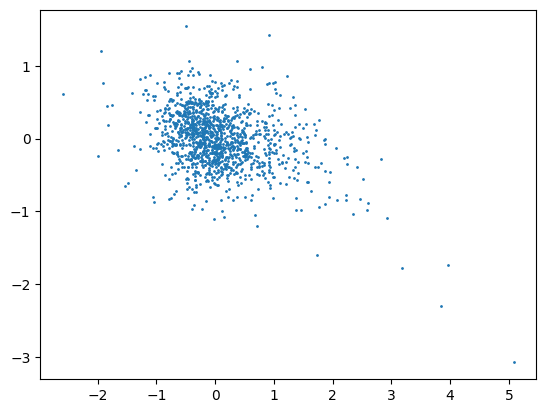

In [19]:
plt.scatter(result_1d.de_coef, result_1d.dv_coef, s=1)

In [20]:
import scipy.stats as stats

In [32]:
result_1d.query('de_coef > 0').sort_values('de_pval')

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,ISG15,stim,5.080402,0.072400,0.000000,-3.078089,0.247370,7.624189e-36
1227,TYMP,stim,1.040268,0.015932,0.000000,-0.196093,0.080140,1.043799e-02
830,OASL,stim,2.932021,0.066728,0.000000,-1.097989,0.254477,8.008181e-06
181,TMSB10,stim,1.383935,0.016835,0.000000,-0.819721,0.079755,4.518163e-25
289,PLSCR1,stim,1.944516,0.033764,0.000000,-0.595210,0.186111,6.961559e-04
...,...,...,...,...,...,...,...,...
806,PPP1R12A,stim,0.006140,0.077811,0.907858,-0.215282,0.437523,4.295663e-01
880,MAPK1IP1L,stim,0.005818,0.081613,0.958046,-0.130543,0.409382,5.538735e-01
1029,LRRC59,stim,0.006930,0.080627,0.965100,-0.007154,0.440360,8.164886e-01
374,PPP2CA,stim,0.003370,0.068399,0.971393,-0.080073,0.436417,7.578383e-01


In [22]:
result_1d.query('dv_coef > 0 & de_coef > 0').sort_values('dv_pval').head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
1212,LGALS1,stim,0.023015,0.018077,2.021538e-01,0.404120,0.064030,2.795219e-10
121,FCER1G,stim,0.158839,0.014969,3.261998e-26,0.275506,0.069536,1.265483e-04
870,FAM177A1,stim,0.911559,0.048237,1.630138e-79,1.422643,0.344612,1.326927e-04
404,SERPINB1,stim,1.227742,0.049077,1.762512e-136,0.855794,0.237509,3.115285e-04
1016,CCR7,stim,1.024241,0.137231,1.159758e-13,0.775692,0.225846,3.215533e-04
835,SAP18,stim,0.800016,0.030087,1.525023e-155,0.989283,0.270967,1.439258e-03
545,SAT1,stim,1.281593,0.023769,0.000000e+00,0.423833,0.142765,1.529260e-03
95,S100A11,stim,0.217213,0.012843,4.375413e-64,0.242905,0.078068,2.875751e-03
79,RHOC,stim,0.319235,0.075610,2.176968e-05,0.727301,0.281768,6.938870e-03
796,DDIT3,stim,0.601545,0.083901,1.144138e-12,0.958445,0.364581,6.978469e-03


### Perform 2D hypothesis testing

For differential coexpression testing, we can specify which genes you want to perform HT on. It takes a list of pairs of genes, where each element in the list is a tuple. Here, we focus on 1 transcription factor and their correlations to rest of the transcriptome. 

Similar to the 1D case, 2D hypothesis testing scales with the number of pairs of genes to test. If you have a smaller set of candidate genes, it will run faster.

In [23]:
import itertools

In [24]:
gene_pairs = list(itertools.product(['IRF7'], adata.var.index.tolist()))

In [25]:
memento.compute_2d_moments(adata, gene_pairs)

In [26]:
memento.ht_2d_moments(
    adata, 
    treatment=treatment_df,
    covariate=cov_df,
    num_boot=5000, 
    verbose=1,
    num_cpus=40)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.7s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.8s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:   56.3s
[Parallel(n_jobs=40)]: Done 1244 out of 1244 | elapsed:  1.6min finished


In [27]:
result_2d = memento.get_2d_ht_result(adata)

In [28]:
result_2d

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval
0,IRF7,ISG15,stim,-0.090297,0.066219,0.190610
1,IRF7,AURKAIP1,stim,0.086841,0.167327,0.605533
2,IRF7,MRPL20,stim,-0.005833,0.148969,0.969739
3,IRF7,SSU72,stim,0.359443,0.138650,0.023014
4,IRF7,GNB1,stim,0.341583,0.137768,0.016571
...,...,...,...,...,...,...
1240,IRF7,PDXK,stim,0.037431,0.065101,0.571260
1241,IRF7,CSTB,stim,0.007205,0.128525,0.955506
1242,IRF7,SUMO3,stim,-0.092811,0.135028,0.495167
1243,IRF7,PTTG1IP,stim,0.129347,0.117603,0.276797


In [29]:
result_2d.sort_values('corr_pval').head(10)

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval
386,IRF7,CD74,stim,0.359478,0.060222,2.413400e-09
429,IRF7,HLA-DRA,stim,0.315053,0.058543,8.042594e-08
430,IRF7,HLA-DRB1,stim,0.294371,0.061903,2.118299e-06
794,IRF7,PTGES3,stim,0.386802,0.081548,2.218425e-06
145,IRF7,GPR137B,stim,0.458225,0.098251,4.610355e-06
734,IRF7,RNASEH2C,stim,0.355312,0.082076,1.574003e-05
438,IRF7,HLA-DPB1,stim,0.264923,0.064454,4.156370e-05
431,IRF7,HLA-DQA1,stim,0.300046,0.072862,4.336529e-05
897,IRF7,CALM1,stim,0.339950,0.083534,4.709414e-05
1114,IRF7,RPS15,stim,0.355355,0.087095,4.718183e-05
